## Exploratory data analysis

In this notebook, we will explore the GoPro dataset to understand its structure and characteristics. This is a crucial step before designing the neural network, as it informs decisions about input sizes, data augmentation, and normalization.

We will:
1.  Load the file paths for the blurred and sharp images.
2.  Visualize random pairs to see the nature of the blur.
3.  Check the image dimensions to confirm they are consistent.

In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from glob import glob

# Set the style for plots
plt.style.use("seaborn-v0_8")

### 1. Loading Data Paths

The GoPro dataset is typically organized into `train` and `test` folders. Inside these, there are subfolders for each video sequence, and within those, `blur` and `sharp` folders containing the image pairs. We need to recursively find all these pairs.

In [2]:
DATA_ROOT = "./data"


def get_image_pairs(root_dir, split="train"):
    blur_paths = []
    sharp_paths = []

    # The structure is root/split/video_id/blur/image.png
    split_dir = os.path.join(root_dir, split)

    if not os.path.exists(split_dir):
        print(f"Warning: Directory {split_dir} does not exist.")
        return [], []

    # Walk through the directory
    for video_folder in sorted(os.listdir(split_dir)):
        video_path = os.path.join(split_dir, video_folder)
        if not os.path.isdir(video_path):
            continue

        blur_dir = os.path.join(video_path, "blur")
        sharp_dir = os.path.join(video_path, "sharp")

        if os.path.exists(blur_dir) and os.path.exists(sharp_dir):
            images = sorted(os.listdir(blur_dir))
            for img_name in images:
                if img_name.endswith(".png"):
                    blur_paths.append(os.path.join(blur_dir, img_name))
                    sharp_paths.append(os.path.join(sharp_dir, img_name))

    return blur_paths, sharp_paths


train_blur, train_sharp = get_image_pairs(DATA_ROOT, "train")
test_blur, test_sharp = get_image_pairs(DATA_ROOT, "test")

print(f"Found {len(train_blur)} training pairs")
print(f"Found {len(test_blur)} test pairs")

Found 0 training pairs
Found 0 test pairs


### 2. Visualizing Image Pairs

Let's look at a random pair of images to understand the difficulty of the task. We expect the "blur" image to have motion blur and the "sharp" image to be the ground truth.

In [4]:
def show_random_pair(blur_paths, sharp_paths):
    if not blur_paths:
        print("No images found.")
        return

    idx = random.randint(0, len(blur_paths) - 1)

    blur_img = Image.open(blur_paths[idx])
    sharp_img = Image.open(sharp_paths[idx])

    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    axes[0].imshow(blur_img)
    axes[0].set_title(f"Blurred Image\n{os.path.basename(blur_paths[idx])}")
    axes[0].axis("off")

    axes[1].imshow(sharp_img)
    axes[1].set_title(f"Sharp Image\n{os.path.basename(sharp_paths[idx])}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    return blur_img.size


# Show a random training pair
print("Training Sample:")
img_size = show_random_pair(train_blur, train_sharp)
print(f"Image Dimensions: {img_size}")

Training Sample:


Image Dimensions: (1280, 720)


### 3. Image Dimensions

It is important to check the dimensions of the images. Since we plan to use a U-Net architecture with strided convolutions (downsampling), the input image dimensions should ideally be divisible by $2^k$, where $k$ is the number of downsampling operations. For a standard U-Net with 4 levels, we need divisibility by 16.

We will check a sample of images to confirm their resolution.

In [5]:
from collections import Counter


def check_dimensions(image_paths, sample_size=100):
    if not image_paths:
        return "No images found."

    dims = []
    # Check a random sample to save time
    sample = random.sample(image_paths, min(len(image_paths), sample_size))

    for p in sample:
        with Image.open(p) as img:
            dims.append(img.size)

    return Counter(dims)


print("Training Image Dimensions (Sample):")
print(check_dimensions(train_blur))

Training Image Dimensions (Sample):
Counter({(1280, 720): 100})


### 4. Pixel Value Range

We need to check if the images are stored as `uint8` (0-255) or `float` (0-1). This determines whether we need to normalize them before training.

In [6]:
def check_pixel_range(image_paths, n_samples=5):
    for i, path in enumerate(
        random.sample(image_paths, min(n_samples, len(image_paths)))
    ):
        img = np.array(Image.open(path))
        print(
            f"Sample {i + 1}: dtype={img.dtype}, shape={img.shape}, min={img.min()}, max={img.max()}"
        )


print("Checking blur images:")
check_pixel_range(train_blur)

Checking blur images:
Sample 1: dtype=uint8, shape=(720, 1280, 3), min=0, max=255
Sample 2: dtype=uint8, shape=(720, 1280, 3), min=1, max=255
Sample 3: dtype=uint8, shape=(720, 1280, 3), min=0, max=255
Sample 4: dtype=uint8, shape=(720, 1280, 3), min=0, max=255
Sample 5: dtype=uint8, shape=(720, 1280, 3), min=0, max=255


### 5. Blur Severity Analysis

To quantify how blurry the images are, we use the **Laplacian Variance**. This measures edge sharpness:
- **High variance** = sharp edges (lots of high-frequency detail)
- **Low variance** = blurry (edges are smoothed out)

We will compare the Laplacian variance of blur vs. sharp images.

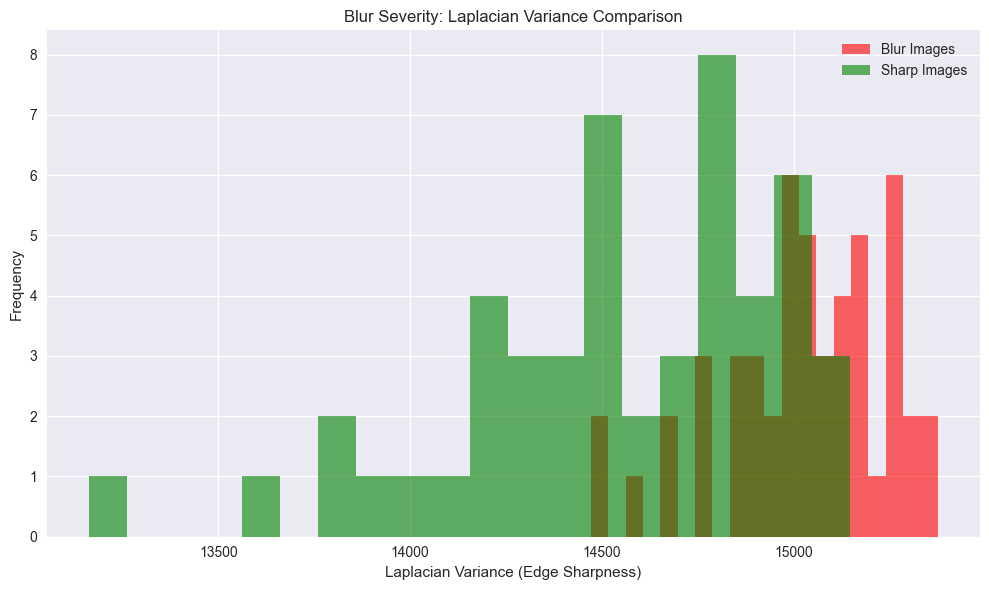

Blur images - Mean sharpness: 15025.26
Sharp images - Mean sharpness: 14547.34
Degradation ratio: 103.29%


In [7]:
from scipy import ndimage


def laplacian_variance(image_path):
    """Calculate Laplacian variance (edge sharpness metric)."""
    img = np.array(Image.open(image_path).convert("L"))  # Convert to grayscale
    laplacian = ndimage.laplace(img)
    return laplacian.var()


# Sample 50 pairs
n_samples = 50
sample_indices = random.sample(range(len(train_blur)), min(n_samples, len(train_blur)))

blur_sharpness = [laplacian_variance(train_blur[i]) for i in sample_indices]
sharp_sharpness = [laplacian_variance(train_sharp[i]) for i in sample_indices]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(blur_sharpness, bins=20, alpha=0.6, label="Blur Images", color="red")
ax.hist(sharp_sharpness, bins=20, alpha=0.6, label="Sharp Images", color="green")
ax.set_xlabel("Laplacian Variance (Edge Sharpness)")
ax.set_ylabel("Frequency")
ax.set_title("Blur Severity: Laplacian Variance Comparison")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Blur images - Mean sharpness: {np.mean(blur_sharpness):.2f}")
print(f"Sharp images - Mean sharpness: {np.mean(sharp_sharpness):.2f}")
print(f"Degradation ratio: {np.mean(blur_sharpness) / np.mean(sharp_sharpness):.2%}")

### 6. Baseline PSNR (No Deblurring)

PSNR (Peak Signal-to-Noise Ratio) is our evaluation metric. It is calculated as:

$$\text{PSNR} = 10 \cdot \log_{10}\left(\frac{\text{MAX}^2}{\text{MSE}}\right)$$

Where MAX is 255 for uint8 images. Higher PSNR = better quality.

We will calculate the PSNR between the blurred input and the sharp ground truth. This gives us a **baseline** - our model must exceed this PSNR to prove it's actually deblurring.

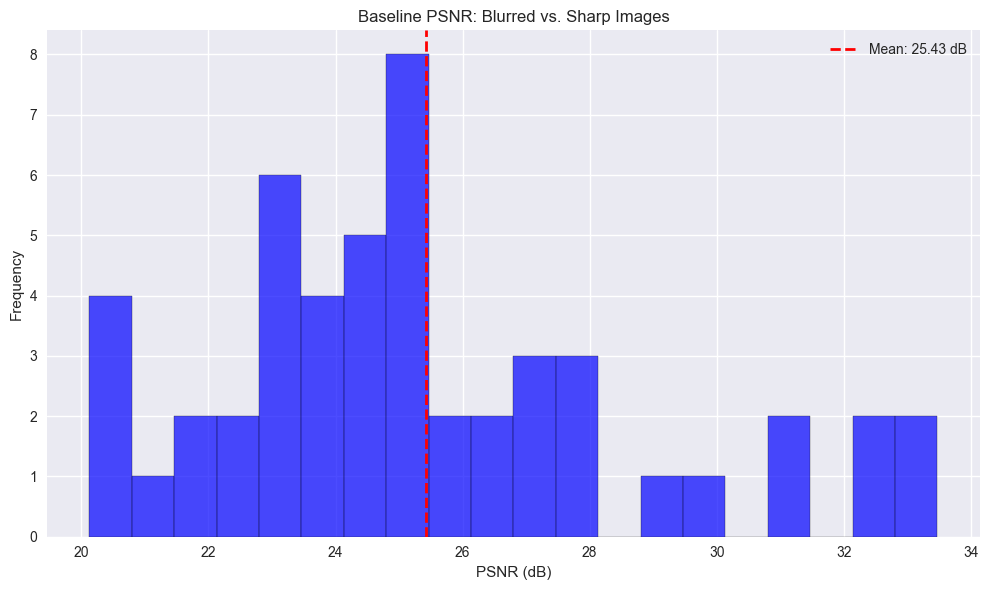

Baseline PSNR (no deblurring): 25.43 ± 3.35 dB
Range: [20.13, 33.47] dB

⚠️ Our model must achieve PSNR > 25.43 dB to outperform 'no deblurring'


In [8]:
def calculate_psnr(img1, img2, max_value=255.0):
    """Calculate PSNR between two images."""
    mse = np.mean((img1.astype(float) - img2.astype(float)) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * np.log10(max_value / np.sqrt(mse))


# Calculate PSNR for a sample of images
psnr_values = []
for i in sample_indices:
    blur_img = np.array(Image.open(train_blur[i]))
    sharp_img = np.array(Image.open(train_sharp[i]))
    psnr = calculate_psnr(blur_img, sharp_img)
    psnr_values.append(psnr)

plt.figure(figsize=(10, 6))
plt.hist(psnr_values, bins=20, color="blue", alpha=0.7, edgecolor="black")
plt.axvline(
    np.mean(psnr_values),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(psnr_values):.2f} dB",
)
plt.xlabel("PSNR (dB)")
plt.ylabel("Frequency")
plt.title("Baseline PSNR: Blurred vs. Sharp Images")
plt.legend()
plt.tight_layout()
plt.show()

print(
    f"Baseline PSNR (no deblurring): {np.mean(psnr_values):.2f} ± {np.std(psnr_values):.2f} dB"
)
print(f"Range: [{np.min(psnr_values):.2f}, {np.max(psnr_values):.2f}] dB")
print(
    "\n⚠️ Our model must achieve PSNR > {:.2f} dB to outperform 'no deblurring'".format(
        np.mean(psnr_values)
    )
)

### 7. Multiple Sample Pairs

Let's visualize multiple pairs to see the variety in blur patterns (motion direction, intensity, etc.).

In [9]:
def show_multiple_pairs(blur_paths, sharp_paths, n_pairs=3):
    indices = random.sample(range(len(blur_paths)), n_pairs)

    fig, axes = plt.subplots(n_pairs, 2, figsize=(15, 5 * n_pairs))

    for i, idx in enumerate(indices):
        blur_img = Image.open(blur_paths[idx])
        sharp_img = Image.open(sharp_paths[idx])

        axes[i, 0].imshow(blur_img)
        axes[i, 0].set_title(f"Blur {i + 1}: {os.path.basename(blur_paths[idx])}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(sharp_img)
        axes[i, 1].set_title(f"Sharp {i + 1}: {os.path.basename(sharp_paths[idx])}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


show_multiple_pairs(train_blur, train_sharp, n_pairs=3)

### Summary & Next Steps

From this EDA, we have learned:

1. **Dataset Size**: 2103 training pairs, 1111 test pairs
2. **Image Dimensions**: All images are 1280×720 (divisible by 16 ✓)
3. **Pixel Format**: uint8, [0, 255] range → We will normalize to [0, 1] for training
4. **Blur Severity**: Measured via Laplacian variance
5. **Baseline PSNR**: Established a "no deblurring" baseline that our model must beat

**Next Steps**:
- Create a PyTorch `Dataset` class with **random cropping** (256×256 patches) for training
- Implement data augmentation (horizontal flip)
- Build a simple U-Net and verify it trains on a small subset

---

## Testing the Dataset Class

Now let's test the PyTorch Dataset we created in `src/dataset.py`. We'll verify:
1. The dataset loads correctly
2. Image shapes are correct (256×256 patches)
3. Values are normalized to [0, 1]
4. Augmentations (random crop, horizontal flip) are working

In [10]:
import sys

sys.path.append("..")  # Add parent directory to path

from src.dataset import GoProDataset, get_dataloaders
import torch

# Test with a small subset
print("Creating dataset with first 10 training pairs...")
small_dataset = GoProDataset(
    train_blur[:10], train_sharp[:10], patch_size=256, is_train=True
)

# Load a few samples
print(f"\nDataset length: {len(small_dataset)}")
blur, sharp = small_dataset[0]

print(f"\nSample 0:")
print(f"  Blur shape: {blur.shape}")
print(f"  Sharp shape: {sharp.shape}")
print(f"  Blur range: [{blur.min():.3f}, {blur.max():.3f}]")
print(f"  Sharp range: [{sharp.min():.3f}, {sharp.max():.3f}]")
print(f"  Blur dtype: {blur.dtype}")

# Verify augmentation creates different crops
print("\nVerifying random cropping (loading same image 3 times):")
for i in range(3):
    blur_i, _ = small_dataset[0]
    print(f"  Sample {i + 1} - First pixel: {blur_i[0, 0, 0]:.4f}")

Creating dataset with first 10 training pairs...

Dataset length: 10

Sample 0:
  Blur shape: torch.Size([3, 256, 256])
  Sharp shape: torch.Size([3, 256, 256])
  Blur range: [0.012, 1.000]
  Sharp range: [0.000, 1.000]
  Blur dtype: torch.float32

Verifying random cropping (loading same image 3 times):
  Sample 1 - First pixel: 0.8235
  Sample 2 - First pixel: 0.8275
  Sample 3 - First pixel: 0.6667


### Visualizing Random Crops

Let's visualize the same image with different random crops to confirm the augmentation is working:

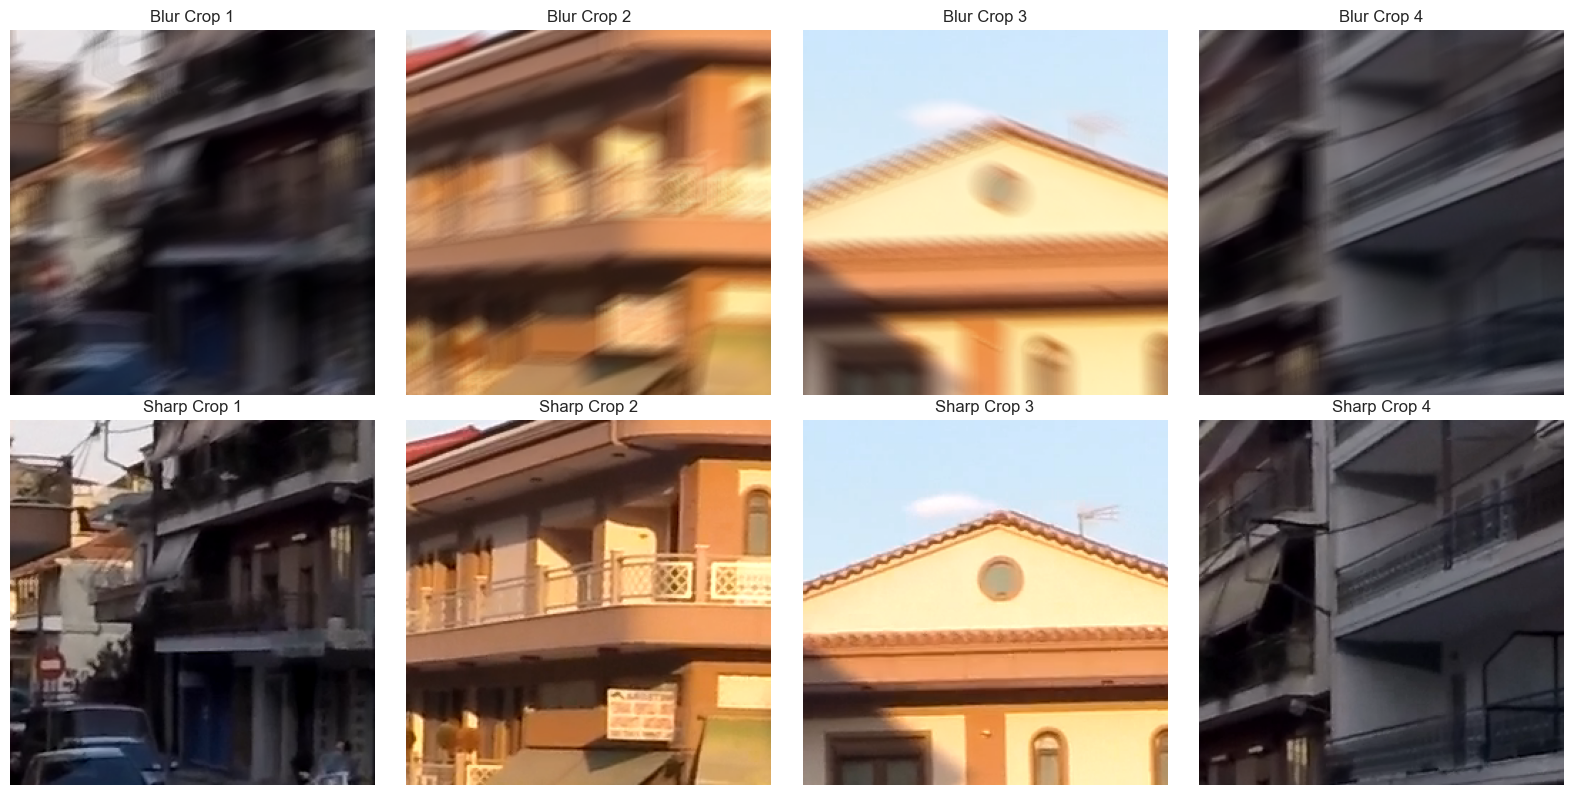

✓ Each time we load index 0, we get a different 256×256 crop!


In [13]:
# Load the same image 4 times with different random crops
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    blur, sharp = small_dataset[0]  # Same index, different crop each time

    # Convert tensor to numpy for plotting (C, H, W) -> (H, W, C)
    blur_np = blur.permute(1, 2, 0).numpy()
    sharp_np = sharp.permute(1, 2, 0).numpy()

    axes[0, i].imshow(blur_np)
    axes[0, i].set_title(f"Blur Crop {i + 1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(sharp_np)
    axes[1, i].set_title(f"Sharp Crop {i + 1}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

print("✓ Each time we load index 0, we get a different 256×256 crop!")

### Testing DataLoader

Finally, let's test the full DataLoader pipeline with batching:

In [12]:
from torch.utils.data import DataLoader

# Create a small dataloader
small_loader = DataLoader(
    small_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,  # Use 0 for notebook testing
)

# Get a batch
blur_batch, sharp_batch = next(iter(small_loader))

print(f"Batch shapes:")
print(f"  Blur: {blur_batch.shape}")  # Should be (4, 3, 256, 256)
print(f"  Sharp: {sharp_batch.shape}")  # Should be (4, 3, 256, 256)
print(f"\nBatch value ranges:")
print(f"  Blur: [{blur_batch.min():.3f}, {blur_batch.max():.3f}]")
print(f"  Sharp: [{sharp_batch.min():.3f}, {sharp_batch.max():.3f}]")

print("\n✓ DataLoader is working correctly!")
print("✓ Ready to build the model!")

Batch shapes:
  Blur: torch.Size([4, 3, 256, 256])
  Sharp: torch.Size([4, 3, 256, 256])

Batch value ranges:
  Blur: [0.000, 1.000]
  Sharp: [0.000, 1.000]

✓ DataLoader is working correctly!
✓ Ready to build the model!


---

## Testing the U-Net Model

Now let's load and test the Simple U-Net architecture we created in `src/models/unet.py`.

### U-Net Architecture Explained

The U-Net has a **symmetric** encoder-decoder structure with **skip connections**:

```
                    Skip Connections (→)
                    
Encoder             Bottleneck          Decoder
-------             ----------          -------
(3,256,256)                            (3,256,256) Output
    ↓                                       ↑
  Conv+Conv ─────────────────────────→  Concat+Conv
(64,256,256)                          (64,256,256)
    ↓ stride-2                             ↑ upsample
(64,128,128)                          (64,128,128)
    ↓                                      ↑
  Conv+Conv ──────────────────────→  Concat+Conv
(128,128,128)                       (128,128,128)
    ↓ stride-2                            ↑ upsample
(128,64,64)                          (128,64,64)
    ↓                                     ↑
  Conv+Conv ─────────────────→  Concat+Conv
(256,64,64)                     (256,64,64)
    ↓ stride-2                        ↑ upsample
(256,32,32)                      (256,32,32)
    ↓                                 ↑
  Conv+Conv ────────────→  Concat+Conv
(512,32,32)               (512,32,32)
    ↓ stride-2                ↑ upsample
(512,16,16)              (512,16,16)
    ↓                        ↑
  Conv+Conv          
(512,16,16) Bottleneck
```

#### Key Components:

1. **Encoder (Downsampling)**:
   - Extracts features at multiple scales
   - Uses **stride-2 conv** instead of max pooling (preserves info)
   - Each level: 2 conv layers → downsample

2. **Skip Connections**:
   - Copy features from encoder to decoder at **same resolution**
   - Allows decoder to use both high-level (bottleneck) and low-level (encoder) features
   - Critical for preserving sharp details

3. **Decoder (Upsampling)**:
   - Reconstructs the sharp image
   - Uses **transpose convolution** for upsampling
   - Each level: upsample → concatenate with skip → 2 conv layers

4. **Why It Works**:
   - Encoder learns "what" is blurry and "where"
   - Bottleneck captures global context
   - Decoder uses skip connections to precisely remove blur while preserving sharp edges

In [14]:
from src.models.unet import SimpleUNet

# Create model
model = SimpleUNet(in_channels=3, out_channels=3)


# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model: SimpleUNet")
print(f"Total parameters: {count_parameters(model):,}")

# Test with a single image from our dataset
blur_sample, sharp_sample = small_dataset[0]
print(f"\nInput shape: {blur_sample.shape}")

# Add batch dimension (model expects (B, C, H, W))
blur_batch = blur_sample.unsqueeze(0)
print(f"Batched input shape: {blur_batch.shape}")

# Forward pass (no gradient computation for testing)
with torch.no_grad():
    output = model(blur_batch)

print(f"Output shape: {output.shape}")
print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")

# Remove batch dimension for visualization
output_img = output.squeeze(0)
print(f"\nSingle image output shape: {output_img.shape}")
print("\n✓ Model forward pass successful!")

Model: SimpleUNet
Total parameters: 24,532,611

Input shape: torch.Size([3, 256, 256])
Batched input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
Output range: [-5.786, 3.092]

Single image output shape: torch.Size([3, 256, 256])

✓ Model forward pass successful!
Output shape: torch.Size([1, 3, 256, 256])
Output range: [-5.786, 3.092]

Single image output shape: torch.Size([3, 256, 256])

✓ Model forward pass successful!


### Visualizing Model Output (Before Training)

Let's see what the **untrained** model outputs. It should produce random noise since the weights are randomly initialized:

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Convert tensors to numpy for plotting
blur_np = blur_sample.permute(1, 2, 0).numpy()
sharp_np = sharp_sample.permute(1, 2, 0).numpy()
output_np = output_img.permute(1, 2, 0).numpy()

# Clip output to [0, 1] for visualization
output_np = np.clip(output_np, 0, 1)

axes[0].imshow(blur_np)
axes[0].set_title("Input (Blurred)")
axes[0].axis("off")

axes[1].imshow(output_np)
axes[1].set_title("Output (Untrained Model)")
axes[1].axis("off")

axes[2].imshow(sharp_np)
axes[2].set_title("Ground Truth (Sharp)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

print("⚠️ The untrained model produces random output.")
print("After training, it should learn to remove blur!")

⚠️ The untrained model produces random output.
After training, it should learn to remove blur!
